# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

**Idea del autoencoder**

* Entrada: una imagen.
* Salida: la misma imagen, suele llamarse **reconstrucción**.

La función de costo contiene una "pérdida de reconstrucción", que penaliza al modelo cuando la reconstrucción es muy distinta del input.

En la capa del medio (una vez que ya se hizo una reducción de dimensionalidad o compresión gracias a poolings y convoluciones), se tiene una idea de cuáles son las features más importantes de la imagen de entrada.

Al hacer la reducción de dimensionalidad, el model aprende una "pseudo-identidad": aproxima la identidad solamente sobre el conjunto de datos.

Encoder: zip, Decoder: unzip.

O sea, los autoencoders son capaces de aprender representaciones eficientes de los datos de entrada, llamadas **codificaciones**.

**Convolución (o filtros):** sirven para reducir "eficientemente" la dimensión de los datos cuya representación "guarda" algún tipo de estructura "espacial".

Importante de las convoluciones: genera varias imágenes a partir de una sola. Cada convolución se concentra en un aspecto particular.

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

In [2]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [3]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [4]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [5]:
# 1.4)
# import google.colab
# from google.colab import files

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
# Extra
from tqdm.notebook import tqdm

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

In [8]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [9]:
labels_names = dict(enumerate(train_set_orig.classes))
labels_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

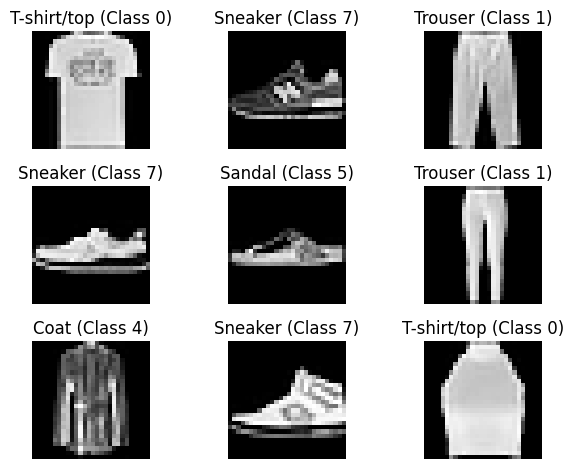

In [10]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    plt.title(f"{labels_names[label]} (Class {label})")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.tight_layout()
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

In [11]:
# 3.1)
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input = output = self.dataset[idx][0]
        return input, output

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [12]:
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

In [13]:
X, y = next(iter(train_set))
print(X.shape)
print(y.shape)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


## Ejercicio 4) Red Neuronal Autoencoder Convolucional





**1)** Defina y cree una red neuronal *autoenconder convolucional* constituida por las siguientes capas:

1. Una capa convolucional 2D constituida por:

* Una capa `Conv2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) que deberá mapear $1$ canal de entradas de dimensiones $(28,28)$ a $16$ canales de de salida de dimensiones $(26,26)$. Para ello utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
* Una capa `ReLU`.
* Una capa `Dropout`.
* Una capa `MaxPool` (ver https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) con un kernel de dimensiones $(2,2)$, de manera que mapeará entradas de dimensiones $(26,26)$ a salidas de dimensiones $(13,13)$.

2. Una capa lineal constituida por:

* Una capa `Flatten` que mapea una entrada de $16$ canales de dimensiones $(13,13)$ a un vector de dimensión $16\times 13\times 13$.
* Una capa `Linear` que mapea un vector de dimensión $16\times 13\times 13$ a un vector de dimensión $n$.
* Una capa `ReLU`.
* Una capa `Dropout`.

3. Una capa capa convolucional 2D transpuesta, constituida por:

* una capa `ConvTranspose2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Para ello, utilice un kernel de dimensiones $(6,6)$ y un stride de dimensiones $(2,2)$, dejando el resto de los parámetros en sus valores por defecto, i.e. padding de $(1,1)$ y out_padding de $(0,0)$.

* Una capa `Sigmoid`.

Nota sobre la función `Conv2d`:
* Input: $N, C_{in}, H_{in}, W_{in}$
* Output: $N, C_{out}, H_{out}, W_{out}$,

donde:
$$
H_{out} = \left\lfloor\frac{H_{in} + 2 \times \text{{padding}}[0] - \text{{dilation}}[0] \times (\text{{kernel\_size}}[0] - 1) - 1}{\text{{stride}}[0]} + 1\right\rfloor
\\
\\
W_{out} = \left\lfloor\frac{W_{in} + 2 \times \text{{padding}}[1] - \text{{dilation}}[1] \times (\text{{kernel\_size}}[1] - 1) - 1}{\text{{stride}}[1]} + 1\right\rfloor
$$

Signficado:
* `padding`: padding added to all four sides of the input. Por defecto, `padding=0`
* `dilation`: spacing between kernel elements. Por defecto, `dilation=1`.
* `stride`: stride of the convolution. Por defecto, `stride=1`.

Como nosotros, vamos a usar los parámetros por defecto para `padding`, `dilation` y `stride`, entonces las fórmulas de arriba se simplfican a:
$$
H_{out} = H_{in} - (\text{{kernel\_size}}[0] - 1)
\\
\\
W_{out} = W_{in} - (\text{{kernel\_size}}[1] - 1)
$$

In [14]:
conv = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3))
max_pool = nn.MaxPool2d(kernel_size=(2,2))
flattener = nn.Flatten(start_dim=1)
linear = nn.Linear(16*13*13, 16*13*13)
unflattener = nn.Unflatten(1, (16,13,13))
conv_trans = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=6, stride=2, padding=1)

orig_img = (train_set[0][0]).unsqueeze(1)
print(f"Original image shape:      {orig_img.shape}")
img = conv(orig_img)
print(f"Convoluted image shape:    {img.shape}")
img = max_pool(img)
print(f"Max pooled img shape:      {img.shape}")
img = flattener(img)
print(f"Flattened image shape:     {img.shape}")
img = linear(img)
print(f"Linearized image shape:    {img.shape}")
img = unflattener(img)
print(f"Unflattened image shape:   {img.shape}")
img = conv_trans(img)
print(f"ConvTranspose image shape: {img.shape}")

print()
print(f"resulting_img.shape == final_img.shape: {orig_img.shape == img.shape}")

Original image shape:      torch.Size([1, 1, 28, 28])
Convoluted image shape:    torch.Size([1, 16, 26, 26])
Max pooled img shape:      torch.Size([1, 16, 13, 13])
Flattened image shape:     torch.Size([1, 2704])
Linearized image shape:    torch.Size([1, 2704])
Unflattened image shape:   torch.Size([1, 16, 13, 13])
ConvTranspose image shape: torch.Size([1, 1, 28, 28])

resulting_img.shape == final_img.shape: True


[W1124 22:00:21.114659366 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


In [15]:
class ConvAutoencoder(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),    # (1,28,28) -> (16,26,26)
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.MaxPool2d(kernel_size=2)    # (16,26,26) -> (16,13,13)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),    # (16,13,13) -> 16x13x13
            nn.Linear(in_features=16*13*13, out_features=16*13*13),    # 16x13x13 -> 16x13x13
            nn.ReLU(),
            nn.Dropout(p=p)
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(16,13,13)),    # 16x13x13 -> (16,13,13)
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=6, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.linear(x)
        x = self.decoder(x)
        return x

**2)** Grafique, a modo de comparación, unas pocas imagenes a predecir vs las correspondientes imagenes predichas utilizando el modelo sin entrenar y dropout $p=0.2$.

In [16]:
def plot_orig_predicted(model, train_set, num_samples=3):
    model_device = next(model.parameters()).device
    model.eval()

    num_samples = 2
    fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(8, 2*num_samples))

    for i in range(num_samples):
        sample_idx = torch.randint(len(train_set), size=(1,)).item()
        input = train_set[sample_idx][0].unsqueeze(1).to(model_device)
        
        with torch.no_grad():
            output = model(input).squeeze(1).cpu().numpy()

        # Plot original image
        ax_orig = axes[i, 0]
        ax_orig.imshow(input.squeeze().cpu().numpy(), cmap='gray')
        ax_orig.axis('off')
        ax_orig.set_title(f"Original {sample_idx}")
        
        # Plot predicted image
        ax_pred = axes[i, 1]
        ax_pred.imshow(output.squeeze(), cmap='gray')
        ax_pred.axis('off')
        ax_pred.set_title(f"Reconstructed {sample_idx}")


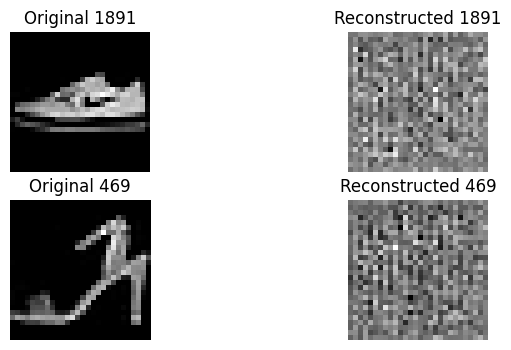

In [17]:
model = ConvAutoencoder(p=0.2)
plot_orig_predicted(model, train_set)

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

In [18]:
def train_step(model, dataloader, loss_fn, optimizer):
    """
    Trains the model for ONE epoch = goes over the dataset one time using the batches.
    """
    num_batches = len(dataloader)
    total_loss = 0
    
    model_device = next(model.parameters()).device
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(model_device), y.to(model_device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        total_loss += loss.item()

        # Backpropagate the prediction loss
        # PyTorch deposits the gradients of the loss w.r.t. each parameter.
        loss.backward()

        # Once we have our gradients, we call optimizer.step() to adjust the parameters
        # by the gradients collected in the backward pass.
        optimizer.step()

        # Reset the gradients of model parameters for the next batch
        optimizer.zero_grad()

        if batch % 100 == 0:
            print(f"Batch {batch} of {num_batches}. Loss in batch: {loss.item():.4f}")
    
    avg_loss = total_loss / num_batches

    return avg_loss

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

In [19]:
# NOTAR: como no es un problema de clasificación, no hay accuracy. Está solamente
# el valor de la pérdida

def validate_step(model, dataloader, loss_fn):
    num_batches = len(dataloader)
    total_loss = 0

    model_device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(model_device), y.to(model_device)

            y_pred = model(X)
            total_loss += loss_fn(y_pred, y).item()

    avg_loss = total_loss / num_batches

    return avg_loss

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

In [20]:
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

batch_size = 100

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

print(f"Cantidad de lotes de entrenamiento: {len(train_loader)}")
print(f"Cantidad de lotes de validación:    {len(valid_loader)}")

Cantidad de lotes de entrenamiento: 600
Cantidad de lotes de validación:    100


**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

In [21]:
loss_fn = nn.MSELoss()

**5)** Cree una instancia del modelo con dropout $p=0.2$.

In [22]:
p = 0.2
model = ConvAutoencoder(p=p)

**6)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

In [23]:
learning_rate = 10e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [25]:
model = model.to(device)

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.
**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

In [26]:
def train_validate_loop(
    model, train_dataloader, valid_dataloader, loss_fn, optimizer, epochs
):
    train_avg_losses_training, train_avg_losses, valid_avg_losses = [], [], []

    for epoch in tqdm(range(1, epochs+1)):
        tqdm.write(f"Epoch {epoch}")
        train_avg_loss_training = train_step(model, train_dataloader, loss_fn, optimizer)

        train_avg_loss = validate_step(model, train_dataloader, loss_fn)
        valid_avg_loss = validate_step(model, valid_dataloader, loss_fn)

        tqdm.write(f"Train avg loss: {train_avg_loss:.6f}")
        tqdm.write(f"Valid avg loss: {valid_avg_loss:.6f}")
        tqdm.write("----------------------------------------------------------------")

        train_avg_losses_training.append(train_avg_loss_training)
        train_avg_losses.append(train_avg_loss)
        valid_avg_losses.append(valid_avg_loss)

    print(f"Training finished! Trained for {epoch} epochs.")
    print(
        f"Final results from epoch {epoch}:\n"
        f"  - Train avg loss: {train_avg_loss:.6f}\n"
        f"  - Valid avg loss: {valid_avg_loss:.6f}"
    )
    return model, train_avg_losses_training, train_avg_losses, valid_avg_losses

**9)** Entrene y valide el modelo.

In [27]:
# Junto todo acá de nuevo. Más fácil de ver los parámetros sin tener que scrollear
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

batch_size = 100

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True , num_workers=10, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=10, pin_memory=True)

loss_fn = nn.MSELoss()

p = 0.2
model = ConvAutoencoder(p=p)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

learning_rate = 10e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epochs = 50

In [28]:
trained_model, train_avg_losses_training, train_avg_losses, valid_avg_losses = train_validate_loop(
    model, train_loader, valid_loader, loss_fn, optimizer, epochs
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
Batch 0 of 600. Loss in batch: 1.3549
Batch 100 of 600. Loss in batch: 0.6888
Batch 200 of 600. Loss in batch: 0.7002
Batch 300 of 600. Loss in batch: 0.6905
Batch 400 of 600. Loss in batch: 0.6935
Batch 500 of 600. Loss in batch: 0.6813
Train avg loss: 0.681359
Valid avg loss: 0.678330
----------------------------------------------------------------
Epoch 2
Batch 0 of 600. Loss in batch: 0.6797
Batch 100 of 600. Loss in batch: 0.6828
Batch 200 of 600. Loss in batch: 0.5977
Batch 300 of 600. Loss in batch: 0.5854
Batch 400 of 600. Loss in batch: 0.5781
Batch 500 of 600. Loss in batch: 0.5848
Train avg loss: 0.589173
Valid avg loss: 0.586912
----------------------------------------------------------------
Epoch 3
Batch 0 of 600. Loss in batch: 0.6103
Batch 100 of 600. Loss in batch: 0.5823
Batch 200 of 600. Loss in batch: 0.6075
Batch 300 of 600. Loss in batch: 0.5851
Batch 400 of 600. Loss in batch: 0.5856
Batch 500 of 600. Loss in batch: 0.5982
Train avg loss: 0.585643
Valid a

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

In [29]:
def losses_plot(
    train_avg_losses_training, train_avg_losses, valid_avg_losses
):
    epochs = len(train_avg_losses)
    epochs_range = range(epochs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, train_avg_losses_training, label="Durante la época", linestyle="--", color="blue")
    plt.plot(epochs_range, train_avg_losses, label="Entrenamiento", linestyle="-", color="green")
    plt.plot(epochs_range, valid_avg_losses, label="Validación", linestyle=":", color="red")
    
    plt.title("Pérdidas durante el entrenamiento")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida promedio por lote")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # experiment_path = os.path.join(EXPERIMENTS_PATH, f"experiment_{timestamp}")
    # os.makedirs(experiment_path, exist_ok=True)

    # with open(os.path.join(experiment_path, "config.json"), "w") as f:
    #     json.dump(config, f)

    # results = {
    #     "train_accuracy": round(train_accs[best_epoch], 4),
    #     "train_avg_loss": round(train_avg_losses[best_epoch], 4),
    #     "valid_accuracy": round(valid_accs[best_epoch], 4),
    #     "valid_avg_loss": round(valid_avg_losses[best_epoch], 4),
    #     "last_epoch": best_epoch
    # }
    # with open(os.path.join(experiment_path, "results.json"), "w") as f:
    #     json.dump(results, f)

    # fig.savefig(os.path.join(experiment_path, "metrics.png"))

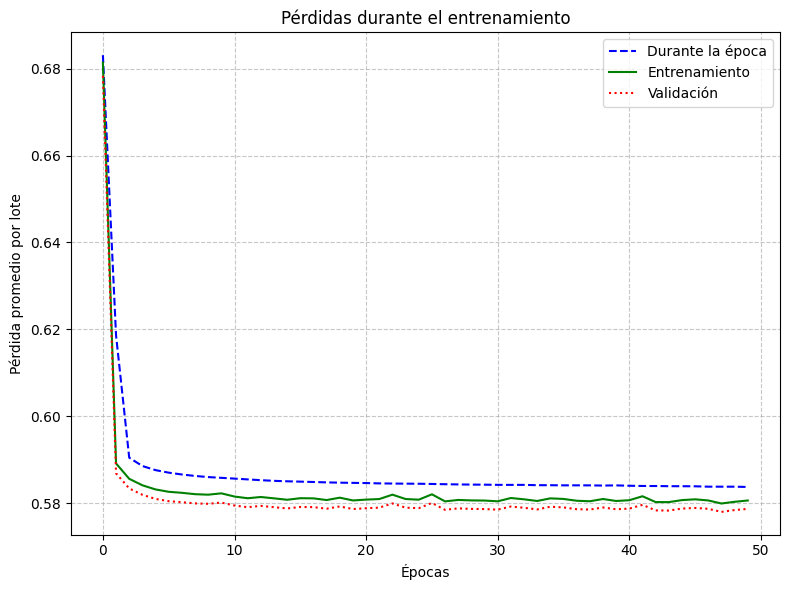

In [30]:
losses_plot(train_avg_losses_training, train_avg_losses, valid_avg_losses)

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

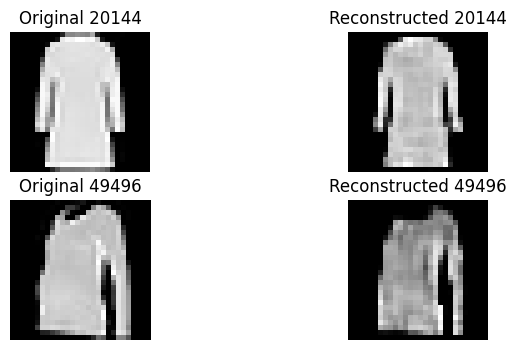

In [39]:
plot_orig_predicted(trained_model, train_set)

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [32]:
# 5.1)